In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data_sets/stock_data.csv")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [3]:
filtered_df = df.loc[(df["Stock"] == "AAPL") & (df["Date"] >= "2008-01-01")]
filtered_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
5879,2008-01-02,25.547,25.646,24.658,24.951,300780650,0,AAPL
5880,2008-01-03,25.034,25.278,24.675,24.964,234652068,0,AAPL
5881,2008-01-04,24.527,24.715,22.910,23.057,405631839,0,AAPL
5882,2008-01-07,23.213,23.510,21.799,22.748,577574252,0,AAPL
5883,2008-01-08,23.060,23.368,21.874,21.932,424241367,0,AAPL


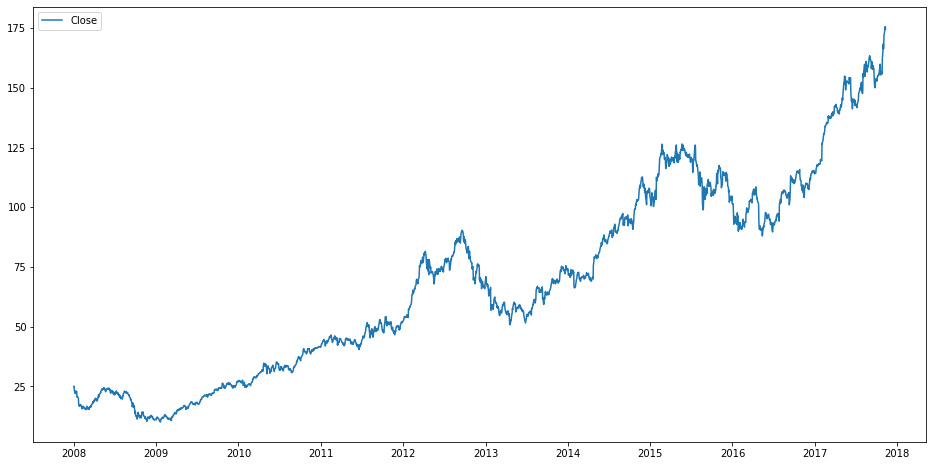

In [4]:
filtered_df.index = pd.to_datetime(filtered_df["Date"])
plt.figure(figsize=(16, 8))
plt.plot(filtered_df["Close"], label='Close')
plt.legend(loc="best")

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
filtered_df = scaler.fit_transform(np.array(filtered_df["Close"]).reshape(-1, 1))
filtered_df

array([[0.09020145],
       [0.09027996],
       [0.07876398],
       ...,
       [1.        ],
       [0.99782603],
       [0.99432353]])

In [7]:
training_size = int(len(filtered_df) * 0.65)
test_size = len(filtered_df) - training_size
train_data, test_data = filtered_df[0:training_size, :], filtered_df[training_size:len(filtered_df), :]

In [8]:
def create_dataset(dataset, time_step=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        data_x.append(a)
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)

step = 100
X_train, y_train = create_dataset(train_data, time_step=step)
X_test, y_test = create_dataset(test_data, time_step=step)

In [9]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

25/25 [==============================] - 1s 28ms/step


In [18]:
import math
from sklearn.metrics import mean_squared_error

In [19]:
math.sqrt(mean_squared_error(y_train, train_predict))

11.530980382456843

In [20]:
initial_df = df.loc[(df["Stock"] == "AAPL") & (df["Date"] >= "2008-01-01")]
initial_df.index = pd.to_datetime(initial_df["Date"])

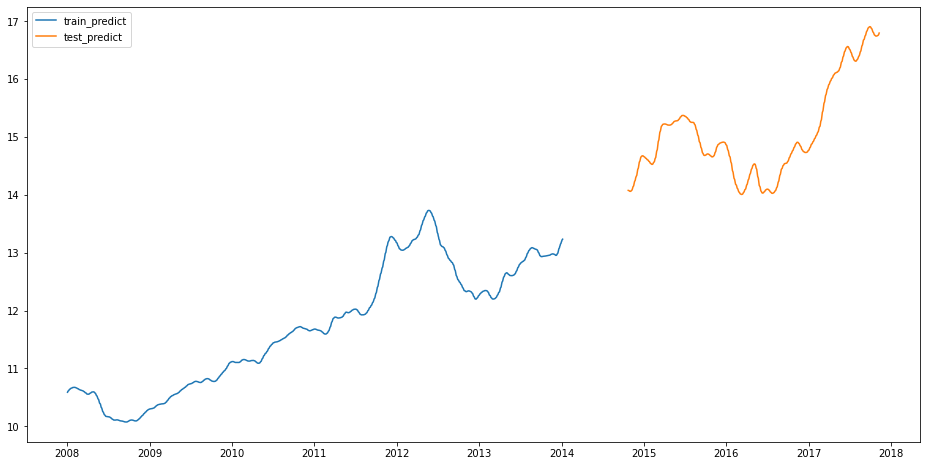

In [21]:
plt.figure(figsize=(16, 8))

train_df = pd.DataFrame(train_predict, index=initial_df.index[:training_size - step - 1])
plt.plot(train_df, label='train_predict')

test_df = pd.DataFrame(test_predict, index=initial_df.index[training_size + step + 1:])
plt.plot(test_df, label='test_predict')

plt.legend(loc="best")